## Summary

### Business understanding



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc,roc_curve

%matplotlib inline

## EDA

#### Data Understanding

Our dataset is from Santander bank over 1.5 year of customer transactions starts at 2015-01-28 and the columns after ind_(xyz)_ult1 #25 is what customers buy and we will predict what will they buy after May 2016 for our test dataset. For our training dataset we have approximately 13m data points  and for test set we have 92 thousand data points.

1. We have dropped the dataset to 10M rows after preprocessing

In [ ]:
df = pd.read_csv('preprocessed_train.csv')

In [ ]:
age = pd.read_csv('age.csv',header=None)

In [28]:
age = age.drop(0,axis=1)
age.head()

,1
0,35
1,23
2,23
3,22
4,23


In [29]:
df_all = df.join(age)

df_all.head()

,Unnamed: 0,date,customerid,employee_index,country_residence,gender,age,date_of_first_holder_contract,new_customer_index,customer_seniority,...,pensions_plan,loans,tax,credit_card,securities,home_account,payroll,pensions,direct_debit,1
0,0,2015-01-28,1375586,3,2,0,151,2015-01-12,0.0,263,...,0,0,0,0,0,0,0.0,0.0,0,35
1,1,2015-01-28,1050611,3,2,1,139,2012-08-10,0.0,292,...,0,0,0,0,0,0,0.0,0.0,0,23
2,2,2015-01-28,1050612,3,2,1,139,2012-08-10,0.0,292,...,0,0,0,0,0,0,0.0,0.0,0,23
3,3,2015-01-28,1050613,3,2,0,138,2012-08-10,0.0,292,...,0,0,0,0,0,0,0.0,0.0,0,22
4,5,2015-01-28,1050615,3,2,0,139,2012-08-10,0.0,292,...,0,0,0,0,0,0,0.0,0.0,0,23


In [30]:
df_all = df_all.drop(['age','Unnamed: 0'],axis=1)
df_all.rename(columns={1:'age'},inplace=True)
df_all.head()

,Unnamed: 0,date,customerid,employee_index,country_residence,gender,date_of_first_holder_contract,new_customer_index,customer_seniority,primary_or_not,...,pensions_plan,loans,tax,credit_card,securities,home_account,payroll,pensions,direct_debit,1
0,0,2015-01-28,1375586,3,2,0,2015-01-12,0.0,263,1.0,...,0,0,0,0,0,0,0.0,0.0,0,35
1,1,2015-01-28,1050611,3,2,1,2012-08-10,0.0,292,1.0,...,0,0,0,0,0,0,0.0,0.0,0,23
2,2,2015-01-28,1050612,3,2,1,2012-08-10,0.0,292,1.0,...,0,0,0,0,0,0,0.0,0.0,0,23
3,3,2015-01-28,1050613,3,2,0,2012-08-10,0.0,292,1.0,...,0,0,0,0,0,0,0.0,0.0,0,22
4,5,2015-01-28,1050615,3,2,0,2012-08-10,0.0,292,1.0,...,0,0,0,0,0,0,0.0,0.0,0,23


#### Analyzing by visuals

We will have a look at some of the obvious characteristic of humans and their relations to out target variables to have a sense of our business case.

We will analyze

1. By Age groups
2. By Gender
3. Residency
4. Income group


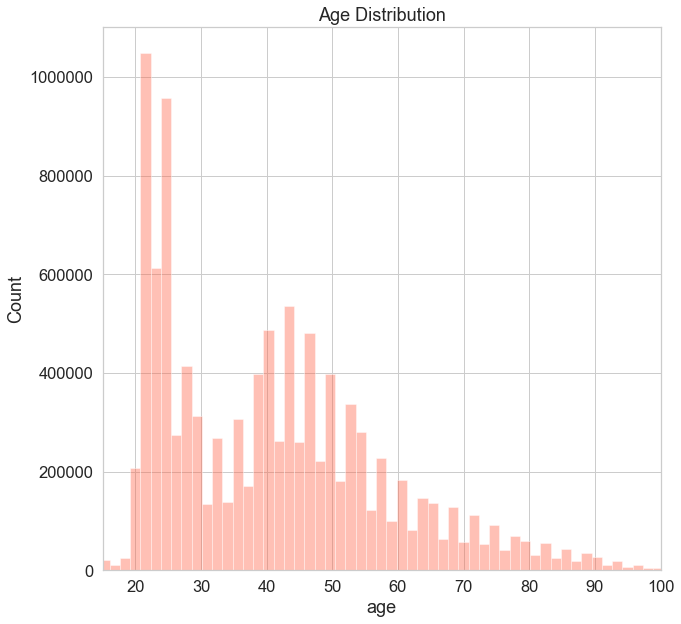

In [89]:
with sns.plotting_context("notebook",font_scale=1.5):
    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    sns.distplot(df_all["age"],
                 bins=80,
                 kde=False,
                 color="tomato")
    plt.title("Age Distribution")
    plt.ylabel("Count")
    plt.xlim((15,100))

In [183]:
df_all['AgeCat'] = pd.cut(df_all.age, bins=np.linspace(df_all.age.min()-1, df_all.age.max(), 11))
df_all['AgeCat'] = df_all['AgeCat'].astype(str)

In [184]:
normalize_vals = df_all['AgeCat'].value_counts()
age_category = df_all.groupby('AgeCat').sum()

In [193]:
normalize_df = pd.DataFrame([normalize_vals.index,normalize_vals]).T

In [186]:
age_category.drop(age_category.iloc[0:1,:21].columns,axis=1,inplace=True)
age_category.drop('age',axis=1,inplace=True)

In [194]:
# WE are going to normalize each age categories behavior according to their number

normalize_df.rename({0:'cat',1:'number'},axis=1,inplace=True)
normalize_df.number = normalize_df.number.astype(int)


,cat,number
0,"(13.6, 26.2]",3167065
1,"(38.8, 51.4]",3038977
2,"(26.2, 38.8]",1932641
3,"(51.4, 64.0]",1480858
4,"(64.0, 76.6]",683632
5,"(76.6, 89.2]",337835
6,"(89.2, 101.8]",87045
7,"(1.0, 13.6]",59120
8,"(101.8, 114.4]",8066
9,"(114.4, 127.0]",153


In [238]:
df_new = pd.DataFrame()
for ind in age_category.index:
    normalizer = int(normalize_df[normalize_df['cat'] == ind ]['number'])
    ser = age_category.loc[ind].div(normalizer,axis=0)
    df_new = df_new.append(ser.T,ignore_index=False)

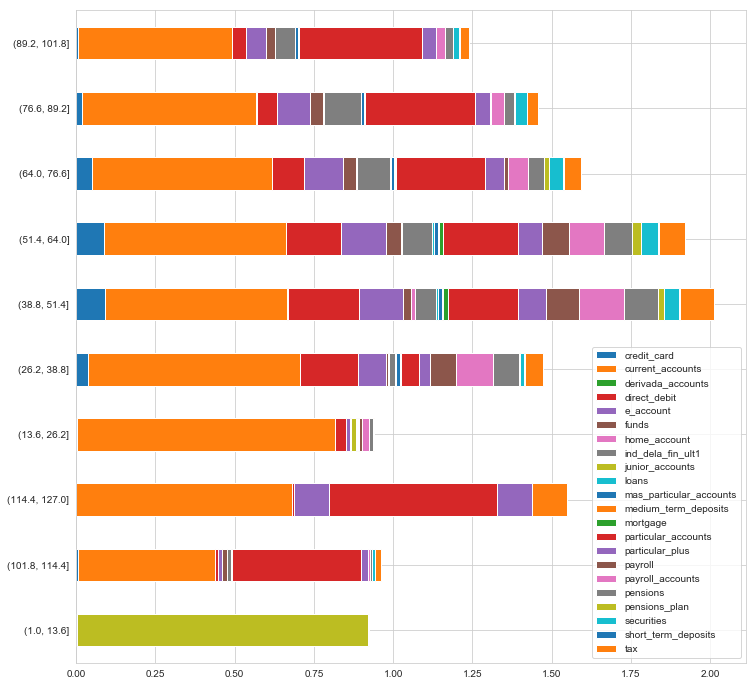

In [240]:

df_new.plot(kind='barh',stacked=True,figsize=(12,12))

### Age related analysis

In [92]:
# Get our target variable dataset
target = df_all.iloc[:,21:].copy()

In [73]:
province = sorted(df_all.groupby('province_name')['gross_income'].median())
gender = df_all.groupby('gender')['gross_income'].median()

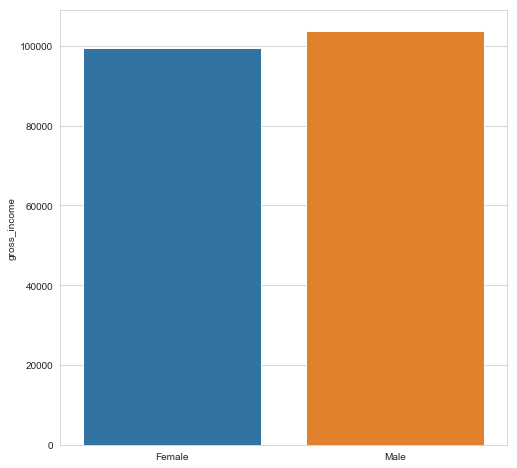

In [90]:
plt.figure(figsize=(8,8))
sns.barplot(['Female','Male'],gender)